# 2. Pandas Intermediate

We have covered a number of features within Pandas, such as the basics of **Series** and **DataFrame**, reading files, checking for missing data, querying/selection, aggregation, sorting/ranking and handling strings.

In this section we're going to cover types of different data, reshaping dataframes and method chaining.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

## Categorical Types

Categoricals are a pandas data type corresponding to categorical variables, such as from statistics. A categorical variable takes on a limited, fixed, number of possible values. Examples include gender, blood type, country or rating. Categorical data may be ordered, but numerical operations are not possible on them.

All of the values in categorical data are either in categories or `np.nan`. Order is defined by the order of *categories*, not the lexical order of the values. Using a categorical data type has a number of **advantages**:

- A string variable consisting of only a few different values can be *efficiently* stored internally as each string is represented by an integer, and only unique strings are in the categories array.
- Sorting through an ordered categorical variable is substantially faster.
- Provides valuable metadata to Pandas when it comes to smart plotting, operations, etc.

Much of this material is drawn from the Pandas documentation, which is extensive and found [here](https://pandas.pydata.org/pandas-docs/stable/categorical.html). 

In [2]:
c = pd.Categorical(['a', 'b', 'b', 'c', 'a', 'b', 'a', 'a', 'a', 'c'])
c

[a, b, b, c, a, b, a, a, a, c]
Categories (3, object): [a, b, c]

In [3]:
c.describe()

,counts,freqs
categories,,
a,5,0.5
b,3,0.3
c,2,0.2


In [4]:
c.codes

array([0, 1, 1, 2, 0, 1, 0, 0, 0, 2], dtype=int8)

In [5]:
# you can provide information as to the ordering of the categories
c.as_ordered()

[a, b, b, c, a, b, a, a, a, c]
Categories (3, object): [a < b < c]

In [6]:
c.dtype

CategoricalDtype(categories=['a', 'b', 'c'], ordered=False)

Converting an existing 'object' feature into a category:

In [43]:
s = pd.Series(["ice", "water", "fire", "fire", "water", "earth", "fire", "fire", "water", "ice"])
s.astype("category")

0      ice
1    water
2     fire
3     fire
4    water
5    earth
6     fire
7     fire
8    water
9      ice
dtype: category
Categories (4, object): [earth, fire, ice, water]

## Time-series / Dates

Datetime uses the NumPy `datetime64` and `timedelta64` dtypes to consolidate a huge amount of work and effect into an efficient new realm of functionality for data analysis. 

In working with time-series data, there are a number of objectives that Pandas fulfills:

- generates sequences of fixed-frequency dates and timespans
- conforms/converts time-series to a particular frequency
- computes 'relative' dates based on various non-standard time increments

More information can be found [here](https://pandas.pydata.org/pandas-docs/stable/timeseries.html).

In [46]:
dates = pd.date_range("1/1/2016", periods=30, freq="D")
dates

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30'],
              dtype='datetime64[ns]', freq='D')

In [8]:
y = pd.Series(np.random.randn(70), index=dates)
y.head()

2016-01-01    0.336373
2016-01-02    0.698391
2016-01-03   -1.514749
2016-01-04    0.240955
2016-01-05   -0.330241
Freq: D, dtype: float64

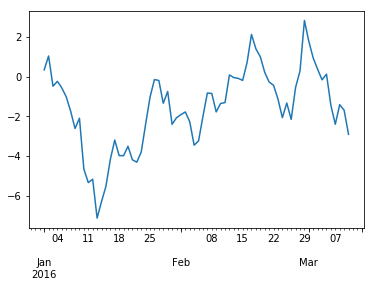

In [9]:
y.cumsum().plot()

When a datetime type is in a DataFrame, there is a special accessor to access the information inside it:

In [10]:
y.index.day

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,
             4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
            21, 22, 23, 24, 25, 26, 27, 28, 29,  1,  2,  3,  4,  5,  6,  7,  8,
             9, 10],
           dtype='int64')

In [11]:
y.index.week

Int64Index([53, 53, 53,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
             3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,
             5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,
             7,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9, 10, 10,
            10, 10],
           dtype='int64')

In [12]:
y.loc["2016-01-01":"2016-01-05"]

2016-01-01    0.336373
2016-01-02    0.698391
2016-01-03   -1.514749
2016-01-04    0.240955
2016-01-05   -0.330241
Freq: D, dtype: float64

Our timeseries is in days, we can easily resample to weeks, months, years etc, depending on the versatility of our data, and interpolate.

In [13]:
y.resample("W").mean()

2016-01-03   -0.159995
2016-01-10   -0.595021
2016-01-17    0.208638
2016-01-24    0.113116
2016-01-31    0.046803
2016-02-07    0.177306
2016-02-14    0.105210
2016-02-21   -0.026431
2016-02-28    0.080002
2016-03-06   -0.247246
2016-03-13   -0.364032
Freq: W-SUN, dtype: float64

Or going to higher frequencies, we can fill in the missing values optionally:

In [14]:
y.asfreq("H", method='ffill').head()

2016-01-01 00:00:00    0.336373
2016-01-01 01:00:00    0.336373
2016-01-01 02:00:00    0.336373
2016-01-01 03:00:00    0.336373
2016-01-01 04:00:00    0.336373
Freq: H, dtype: float64

Lagging/rolling timeseries is trivial:

In [15]:
y.shift(1).head()

2016-01-01         NaN
2016-01-02    0.336373
2016-01-03    0.698391
2016-01-04   -1.514749
2016-01-05    0.240955
Freq: D, dtype: float64

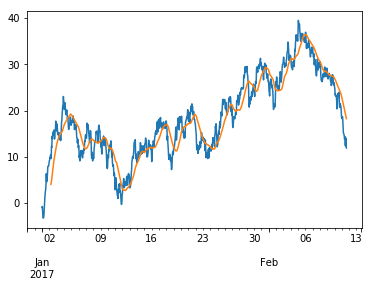

In [16]:
y_cum = pd.Series(np.random.randn(1000), index=pd.date_range("1/1/2017", periods=1000, freq="H")).cumsum()
y_cum.plot()
roll = y_cum.rolling(window=30).mean().plot()

## Reshaping DataFrame objects

In the context of a single DataFrame, we are often interested in re-arranging the layout of our data; particularly for machine learning where algorithms for prediction rely on strict criteria for $X$ and $y$ inputs.

To illustrate this, we will work with a dataset from "*Statistical Methods for the Analysis of Repeated Measurements by Charles S. Davis, pp. 161-163 (Springer, 2002)*", which handles some data from a controlled trial of botulinum toxin type B (BoTB) in patients with cervical dystonia.
* Response variable: (twstrs), measuring severity, pain, and disability caused from cervical dystonia.
* Measured multiple times per patient in weeks 0, 2, 4, 8, 12 and 16.

In [17]:
cdystonia = pd.read_csv("datasets/cdystonia.csv")
cdystonia.head(10)

,patient,obs,week,site,id,treat,age,sex,twstrs
0,1,1,0,1,1,5000U,65,F,32
1,1,2,2,1,1,5000U,65,F,30
2,1,3,4,1,1,5000U,65,F,24
3,1,4,8,1,1,5000U,65,F,37
4,1,5,12,1,1,5000U,65,F,39
5,1,6,16,1,1,5000U,65,F,36
6,2,1,0,1,2,10000U,70,F,60
7,2,2,2,1,2,10000U,70,F,26
8,2,3,4,1,2,10000U,70,F,27
9,2,4,8,1,2,10000U,70,F,41


We could use the *stack()* method to rotate the dataframe, so that columns are represented as rows:

In [45]:
cdystonia.stack().head(15)

0  patient        1
   obs            1
   week           0
   site           1
   id             1
   treat      5000U
   age           65
   sex            F
   twstrs        32
1  patient        1
   obs            2
   week           2
   site           1
   id             1
   treat      5000U
dtype: object

We could create a **hierarchical index** with this to make the data more understandable:

In [19]:
cdystonia2 = cdystonia.set_index(['patient','obs']).drop("id",axis=1)
cdystonia2.head(10)

week  site   treat  age sex  twstrs
patient obs                                     
1       1       0     1   5000U   65   F      32
        2       2     1   5000U   65   F      30
        3       4     1   5000U   65   F      24
        4       8     1   5000U   65   F      37
        5      12     1   5000U   65   F      39
        6      16     1   5000U   65   F      36
2       1       0     1  10000U   70   F      60
        2       2     1  10000U   70   F      26
        3       4     1  10000U   70   F      27
        4       8     1  10000U   70   F      41

We could disregard most of the table, and unstack the response variable in columns to make it 'per patient':

In [20]:
twstrs_wide = cdystonia2.twstrs.unstack("obs")
twstrs_wide.head()

obs,1,2,3,4,5,6
patient,,,,,,
1,32.0,30.0,24.0,37.0,39.0,36.0
2,60.0,26.0,27.0,41.0,65.0,67.0
3,44.0,20.0,23.0,26.0,35.0,35.0
4,53.0,61.0,64.0,62.0,NaN,NaN
5,53.0,35.0,48.0,49.0,41.0,51.0


Now we could re-merge this back into the original dataset with observation and twstrs as column-data, making a wide-format:

In [21]:
cdystonia_wide = (cdystonia[['patient','site','treat','age','sex']]
     .drop_duplicates()
     .merge(twstrs_wide, right_index=True, left_on="patient", how='inner'))
cdystonia_wide.head()

,patient,site,treat,age,sex,1,2,3,4,5,6
0,1,1,5000U,65,F,32.0,30.0,24.0,37.0,39.0,36.0
6,2,1,10000U,70,F,60.0,26.0,27.0,41.0,65.0,67.0
12,3,1,5000U,64,F,44.0,20.0,23.0,26.0,35.0,35.0
18,4,1,Placebo,59,F,53.0,61.0,64.0,62.0,NaN,NaN
22,5,1,10000U,76,F,53.0,35.0,48.0,49.0,41.0,51.0


We can revert back to long-form using `melt()`.

In [22]:
pd.melt(cdystonia_wide, id_vars=["patient","site","treat","age","sex"], var_name="obs", value_name="twstrs").head()

,patient,site,treat,age,sex,obs,twstrs
0,1,1,5000U,65,F,1,32.0
1,2,1,10000U,70,F,1,60.0
2,3,1,5000U,64,F,1,44.0
3,4,1,Placebo,59,F,1,53.0
4,5,1,10000U,76,F,1,53.0


Alternatively we can use pivots:

In [23]:
cdystonia.pivot(index="patient", columns="week", values="twstrs").head()

week,0,2,4,8,12,16
patient,,,,,,
1,32.0,30.0,24.0,37.0,39.0,36.0
2,60.0,26.0,27.0,41.0,65.0,67.0
3,44.0,20.0,23.0,26.0,35.0,35.0
4,53.0,61.0,64.0,62.0,NaN,NaN
5,53.0,35.0,48.0,49.0,41.0,51.0


This can include hierarchical indexing/columns, making a *pivot-table*:

In [24]:
cdystonia.pivot_table(index=["patient","id"], columns=["week","obs"], values="twstrs").head()

,week,0,2,4,8,12,16
,obs,1,2,3,4,5,6
patient,id,,,,,,
1,1,32.0,30.0,24.0,37.0,39.0,36.0
2,2,60.0,26.0,27.0,41.0,65.0,67.0
3,3,44.0,20.0,23.0,26.0,35.0,35.0
4,4,53.0,61.0,64.0,62.0,NaN,NaN
5,5,53.0,35.0,48.0,49.0,41.0,51.0


## MultiIndex and Multicolumns

## Method Chaining

You notice in one of the above examples of merging the wide-format into the whole dataset, we used function chaining to get what we wanted.

Let's say we wanted to perform a series of different operations on this data to obtain a more useful column/metric and output:

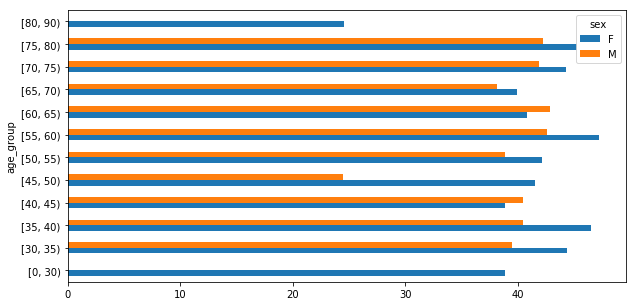

In [25]:
(cdystonia.assign(age_group=pd.cut(cdystonia.age, [0, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90], right=False))
    .groupby(['age_group','sex']).mean()
    .twstrs.unstack("sex")
    .fillna(0.0)
    .plot.barh(figsize=(10,5)))

## Pipes

One of the problems with method chaining is that it requires all of the functionality you need for data processing to be implemented somewhere as methods which return the actual DataFrame object in order to chain. Occasionally we want to do custom manipulations to our data, this is solved in *pipe*.

For example, we may wish to calculate the *proportion of twstrs* in the whole dataset to see differences between each patient in proportional terms across time to all of the other patients in their age group, their state of pain etc.

In [26]:
def to_proportions(df, axis=1):
    row_totals = df.sum(axis)
    return df.div(row_totals, True - axis)

(cdystonia.assign(age_group=pd.cut(cdystonia.age, [0, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90], right=False))
    .groupby(["week","age_group"]).mean()
    .twstrs.unstack("age_group")
    .pipe(to_proportions, axis=1))

age_group,"[0, 30)","[30, 35)","[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 90)"
week,,,,,,,,,,,,
0,0.077768,0.086100,0.090993,0.082132,0.078693,0.089248,0.087231,0.086857,0.077027,0.086563,0.090729,0.066658
2,0.109625,0.074226,0.104079,0.086025,0.081267,0.083198,0.091862,0.085873,0.080638,0.083075,0.085873,0.034258
4,0.062810,0.074888,0.102670,0.085481,0.088175,0.088900,0.096772,0.090262,0.085196,0.091497,0.094698,0.038652
8,0.080700,0.092696,0.089113,0.083385,0.082088,0.084907,0.095968,0.087442,0.082102,0.087244,0.097277,0.037079
12,0.074513,0.097672,0.085733,0.083962,0.076862,0.089694,0.091690,0.085497,0.084294,0.095155,0.090623,0.044305
16,0.078422,0.092100,0.086238,0.074634,0.075534,0.080489,0.092476,0.080743,0.080526,0.095064,0.089000,0.074774


We can now see the proportion of response variable across the age groups, per week.

## Data Transformation

We have several options for *transforming* labels and other columns into more useful features:

In [27]:
cdystonia.treat.replace({'Placebo': 0, "5000U": 1, "10000U": 2}).head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    2
7    2
8    2
9    2
Name: treat, dtype: int64

In [28]:
cdystonia.treat.astype("category").head(10)

0     5000U
1     5000U
2     5000U
3     5000U
4     5000U
5     5000U
6    10000U
7    10000U
8    10000U
9    10000U
Name: treat, dtype: category
Categories (3, object): [10000U, 5000U, Placebo]

In [29]:
pd.cut(cdystonia.age, [20,40,60,80], labels=["Young","Middle-Aged","Old"])[-25:]

606            Old
607            Old
608            Old
609            Old
610    Middle-Aged
611    Middle-Aged
612    Middle-Aged
613    Middle-Aged
614    Middle-Aged
615    Middle-Aged
616    Middle-Aged
617    Middle-Aged
618    Middle-Aged
619    Middle-Aged
620          Young
621          Young
622          Young
623          Young
624          Young
625          Young
626    Middle-Aged
627    Middle-Aged
628    Middle-Aged
629    Middle-Aged
630    Middle-Aged
Name: age, dtype: category
Categories (3, object): [Young < Middle-Aged < Old]

We can use qcut to automatically divide our data into even-sized $q$-tiles. For example $q=4$ refers to quartiles.

In [30]:
pd.qcut(cdystonia.age, 4)[-10:]

621    (25.999, 46.0]
622    (25.999, 46.0]
623    (25.999, 46.0]
624    (25.999, 46.0]
625    (25.999, 46.0]
626      (56.0, 65.0]
627      (56.0, 65.0]
628      (56.0, 65.0]
629      (56.0, 65.0]
630      (56.0, 65.0]
Name: age, dtype: category
Categories (4, interval[float64]): [(25.999, 46.0] < (46.0, 56.0] < (56.0, 65.0] < (65.0, 83.0]]

## Sparse Dataframes

*Sparse* version of Series and DataFrame are implemented in Pandas. They are not sparse in the typical sense, rather these objects are **compressed** where any data matching a specific value (`NaN`/missing) is omitted. A special `SparseIndex` object tracks where data has been *sparsified*. See this example:

In [31]:
ts = pd.Series(np.random.randn(10))
ts[2:-2] = np.nan
sts = ts.to_sparse()
sts

0   -1.879110
1   -0.838231
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8    0.969035
9   -1.291883
dtype: float64
BlockIndex
Block locations: array([0, 8], dtype=int32)
Block lengths: array([2, 2], dtype=int32)

The `to_sparse()` method allows us to fill the value with something other than `NaN`:

In [32]:
ts.fillna(0.).to_sparse(fill_value=0)

0   -1.879110
1   -0.838231
2    0.000000
3    0.000000
4    0.000000
5    0.000000
6    0.000000
7    0.000000
8    0.969035
9   -1.291883
dtype: float64
BlockIndex
Block locations: array([0, 8], dtype=int32)
Block lengths: array([2, 2], dtype=int32)

These Sparse objects are mostly useful for memory-efficient reasons. Suppose you had a mostly `NaN` DataFrame:

In [33]:
df = pd.DataFrame(np.random.rand(100,100))
df_sp = df.where(df < 0.02).to_sparse()
print(df_sp.density)
df_sp.head()

0.0199


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.019456,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
print("Memory usage [sparse]: %d bytes\nMemory usage [dense]: %d bytes" % (df_sp.memory_usage().sum(), df.memory_usage().sum()))

Memory usage [sparse]: 1672 bytes
Memory usage [dense]: 80080 bytes


Pandas also supports creating sparse dataframes directly from `scipy.sparse` matrices. It is worth mentioning that Pandas converts scipy matrices NOT in COOrdinate format to COO, copying data as needed. 

In [35]:
from scipy import sparse

scip_sps = sparse.coo_matrix(np.random.choice([0,1], size=(1000,1000), p=(.95, .05)))
scip_sps

<1000x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 50007 stored elements in COOrdinate format>

In [36]:
sdf = pd.SparseDataFrame(scip_sps)
sdf.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We **highly recommend** you check out the [cookbook](https://pandas.pydata.org/pandas-docs/stable/cookbook.html) for efficient ways of handling and processing your pandas.DataFrames.

## Tasks

You're going to be working with the OpenfMRI dataset found [here](http://www.openfmri.org/dataset/). It exists within the `datasets/` directory so there is no need to download it.

### Task 1

Import the fMRI dataset. Convert the `event` and `region` features into categorical types.

In [37]:
fmri = pd.read_csv("datasets/fmri.csv")
fmri.head()

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970


In [39]:
fmri.event = fmri.event.astype("category")
fmri.region = fmri.region.astype("category")

In [40]:
fmri.dtypes

subject        object
timepoint       int64
event        category
region       category
signal        float64
dtype: object

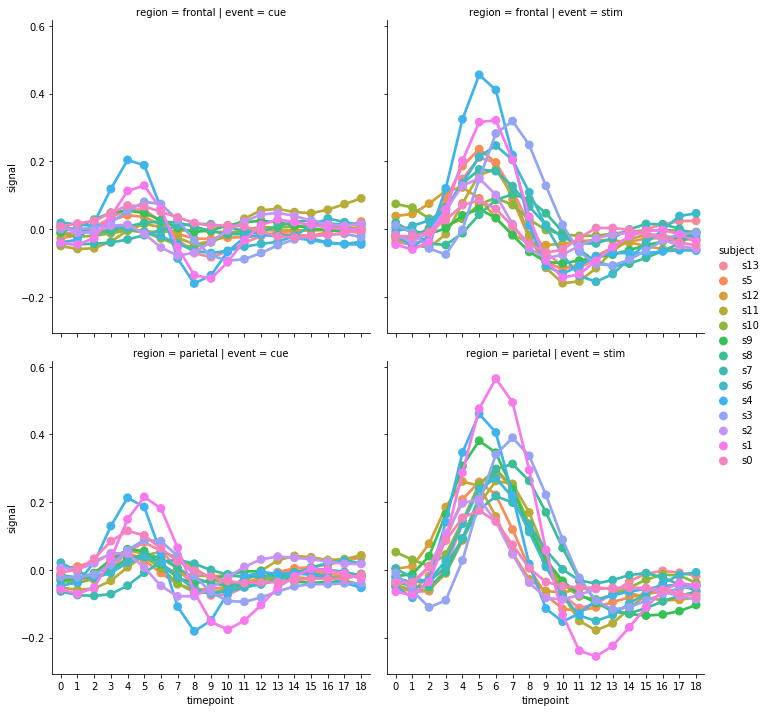

In [41]:
import seaborn as sns
sns.catplot(x="timepoint", y="signal", hue="subject", col="event", row="region", data=fmri, kind="point", alpha=.5)

### Task 2

RESHAPE 1

### Task 3

RESHAPE 2

### Task 4

WRITING A CUSTOM PIPE

### Task 5

In [33]:
pd.crosstab?